# Deep Computer Vision Using Convolutional Neural Networks

Convolutional neural networks (CNNs) emerged from the study of the brain’s visual cortex, and they have been used in image recognition since the 1980s. In the last few years, thanks to the increase in computational power, the amount of available training data, and the tricks presented in Chapter 11 for training deep nets, CNNs have managed to achieve superhuman performance on some complex visual tasks. They power image search services, self-driving cars, automatic video classification systems, and more. Moreover, CNNs are not restricted to visual perception: they are also successful at many other tasks, such as voice recognition and natural language processing. However, we will focus on visual applications for now.

In this chapter we will explore where CNNs came from, what their building blocks look like, and how to implement them using TensorFlow and Keras. Then we will discuss some of the best CNN architectures, as well as other visual tasks, including object detection (classifying multiple objects in an image and placing bounding boxes around them) and semantic segmentation (classifying each pixel according to the class of the object it belongs to).

## The Architecture of the Visual Cortex

David H. Hubel and Torsten Wiesel performed a series of experiments on cats in 1958 and 1959 (and a few years later on monkeys3 ), giving crucial insights into the structure of the visual cortex (the authors received the Nobel Prize in Physiology or Medicine in 1981 for their work). In particular, they showed that many neurons in the visual cortex have a small local receptive field, meaning they react only to visual stimuli located in a limited region of the visual field.

Moreover, the authors showed that some neurons react only to images of horizontal lines, while others react only to lines with different orientations (two neurons may have the same receptive field but react to different line orientations). They also noticed that some neurons have larger receptive fields, and they react to more complex patterns that are combinations of the lower-level patterns. These observations led to the idea that the higher-level neurons are based on the outputs of neighboring lower-level neurons.

These studies of the visual cortex inspired the neocognitron, introduced in 1980, which gradually evolved into what we now call convolutional neural networks. An important milestone was a 1998 paper by Yann LeCun et al. that introduced the famous LeNet-5 architecture, widely used by banks to recognize handwritten check numbers. This architecture has some building blocks that you already know, such as fully connected layers and sigmoid activation functions, but it also introduces two new building blocks: convolutional layers and pooling layers. Let’s look at them now.

In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow import keras

### Why use CNNs

Why not simply use a deep neural network with fully connected layers for image recognition tasks? Unfortunately, although this works fine for small images (e.g., MNIST), it breaks down for larger images because of the huge number of parameters it requires. For example, a 100 × 100–pixel image has 10,000 pixels, and if the first layer has just 1,000 neurons (which already severely restricts the amount of information transmitted to the next layer), this means a total of 10 million connections. And that’s just the first layer. CNNs solve this problem using partially connected layers and weight sharing.

## Convolutional Layers

### What is Convolution

The most important building block of a CNN is the convolutional layer: A convolution is a mathematical operation that slides one function over another and measures the integral of their pointwise multiplication. It has deep connections with the Fourier transform and the Laplace transform and is heavily used in signal processing. Convolutional layers actually use cross-correlations, which are very similar to convolutions.
 

### Connections in Convolution Layer

Neurons in the first convolutional layer are not connected to every single pixel in the input image (like they were in the layers discussed in previous chapters), but only to pixels in their receptive fields. In turn, each neuron in the second convolutional layer is connected only to neurons located within a small rectangle in the first layer. This architecture allows the network to concentrate on small low-level features in the first hidden layer, then assemble them into larger higher-level features in the next hidden layer, and so on.

This hierarchical structure is common in real-world images, which is one of the reasons why CNNs work so well for image recognition.

A neuron located in row i, column j of a given layer is connected to the outputs of the neurons in the previous layer located in rows i to i + fh – 1, columns j to j + fw – 1, where fh and fw are the height and width of the receptive field.

In order for a layer's neurons to have connections with the same height and width from the previous layer, it is common to add zeros around the inputs, this is called zero padding.


It is also possible to connect a large input layer to a much smaller layer by spacing out the receptive fields, so instead of sliding with a stride of 1, you slide with stride of 2. This dramatically reduces the model’s computational complexity. The shift from one receptive field to the next is called the stride.

#### Connection example

For example, consider a 5 × 7 input layer (plus zero padding) is connected to a 3 × 4 layer, using 3 × 3 receptive fields and a stride of 2 (in this example the stride is the same in both directions, but it does not have to be so). A neuron located in row i, column j in the upper layer is connected to the outputs of the neurons in the previous layer located in rows i × sh to i × sh + fh – 1, columns j × sw to j × sw + fw – 1, where sh and sw are the vertical and horizontal strides.

#### Benefit of CNNs

All the multilayer neural networks we’ve looked at so far had layers composed of a long line of neurons, and we had to flatten input images to 1D before feeding them to the neural network. In a CNN each layer is represented in 2D, which makes it easier to match neurons with their corresponding inputs.

## Filters

A neuron’s weights can be represented as a small image the size of the receptive field.

In [2]:
import numpy as np
from sklearn.datasets import load_sample_image

# Load sample images
china = load_sample_image("china.jpg") / 255
flower = load_sample_image("flower.jpg") / 255
images = np.array([china, flower])
batch_size, height, width, channels = images.shape

In [3]:
def plot_image(image,title):
    plt.imshow(image, cmap="gray", interpolation="nearest")
    plt.title(title)
    plt.axis("off")

def plot_color_image(image):
    plt.imshow(image, interpolation="nearest")
    plt.axis("off")

def crop(images):
    return images[150:220, 130:250]

In [4]:
images.shape

(2, 427, 640, 3)

In [5]:
batch_size

2

In [6]:
channels

3

In [7]:
flower.shape

(427, 640, 3)

In [8]:
china.shape

(427, 640, 3)

### Creating 2 filter

In [9]:
# Create 2 filters
filters = np.zeros(shape=(7, 7, channels, 2), dtype=np.float32)
filters[:, 3, :, 0] = 1 # vertical line
filters[3, :, :, 1] = 1 # horizontal line

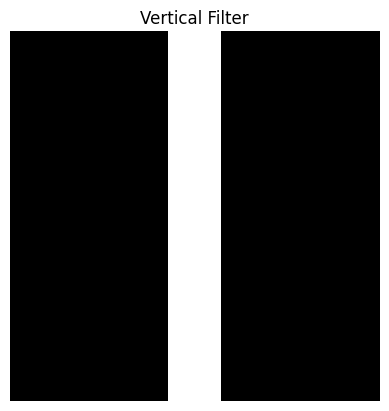

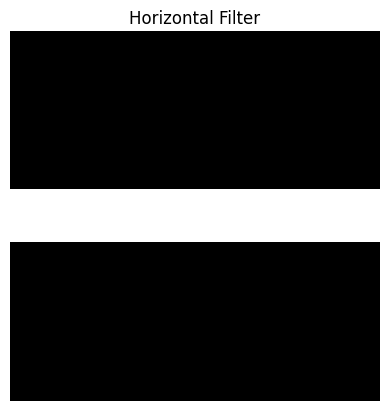

In [10]:
plot_image(filters[:, :, 0, 0],title='Vertical Filter')
plt.show()
print('\n\n\n\n\n\n')
plot_image(filters[:, :, 0, 1],title='Horizontal Filter')
plt.show()

In [11]:
filters.shape # Basically an array of arrays, so the outer array is of shape 7x7 and each array in this 7x7 is of the shape 3x2

(7, 7, 3, 2)

In [12]:
filters[:, 3, :, 0] = 1  # vertical line
filters[3, :, :, 1] = 1  # horizontal line

In [13]:
outputs = tf.nn.conv2d(images, filters, strides=1, padding="SAME")

In [14]:
outputs.shape


TensorShape([2, 427, 640, 2])

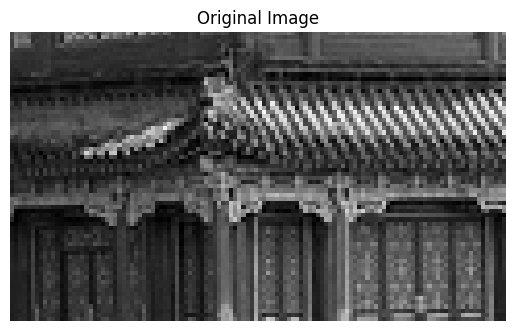

In [15]:
plot_image(crop(images[0, :, :, 0]),title='Original Image') # A neuron’s weights can be represented as a small image the size of the receptive field.
plt.axis("off") # Not shown in the book
plt.title('Original Image')
plt.show()

## Understanding filter

For example, consider two possible sets of weights, called filters (or convolution kernels). The first one is represented as a black square with a vertical white line in the middle (it is a 7 × 7 matrix full of 0s except for the central column, which is full of 1s, filters[:, 3, :, 0] = 1 ); neurons using these weights will ignore everything in their receptive field except for the central vertical line (since all inputs will get multiplied by 0, except for the ones located in the central vertical line). 

The second filter is a black square with a horizontal white line in the middle. Once again, neurons using these weights will ignore everything in their receptive field except for the central horizontal line(filters[3, :, :, 1] = 1  # horizontal line).

## Running the filters on the image

###  Vertical filter

Now if all neurons in a layer use the same vertical line filter (and the same bias term), the filters[:, 3, :, 0] = 1  # vertical line and you feed the network the Original input image shown above, then the layer will output the below image. Notice that the vertical white lines get enhanced while the rest gets blurred. 

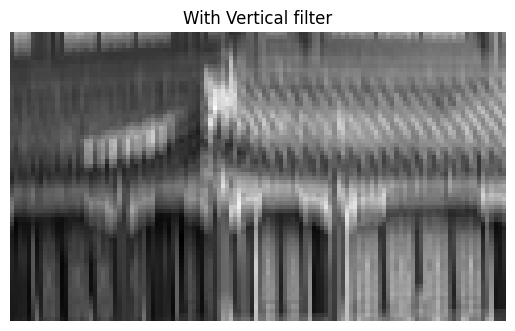

In [16]:
plot_image(crop(outputs[0, :, :, 0]),title='With Vertical filter')

### Horizontal Filter

Similarly, the below image is what you get if all neurons use the same horizontal line filter(filters[3, :, :, 1] = 1  # horizontal line); notice that the horizontal white lines get enhanced while the rest is blurred out. 

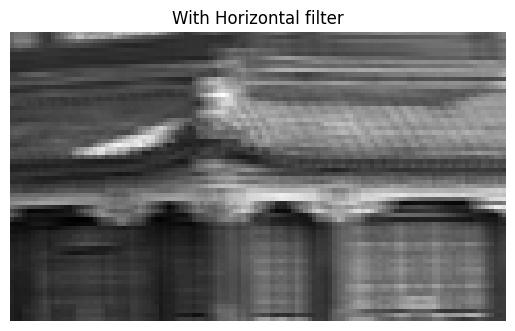

In [17]:
plot_image(crop(outputs[0, :, :, 1]),title='With Horizontal filter')

### Conclusion Filter

Thus, a layer full of neurons using the same filter outputs a feature map, which highlights the areas in an image that activate the filter the most. Of course, you do not have to define the filters manually: instead, during training the convolutional layer will automatically learn the most useful filters for its task, and the layers above will learn to combine them into more complex patterns.


## Stacking Multiple Feature Maps

Up to now, for simplicity, we have represented the output of each convolutional layer as a 2D layer, but in reality a convolutional layer has multiple filters (you decide how many) and outputs one feature map per filter, so it is more accurately represented in 3D.

A convolutional layer has one neuron per pixel in each feature map, and all neurons within a given feature map share the same parameters (i.e., the same weights and bias term). Neurons in different feature maps use different parameters. A neuron’s receptive field is the same as described earlier, but it extends across all the previous layers’ feature maps. In short, a convolutional layer simultaneously applies multiple trainable filters to its inputs, making it capable of detecting multiple features anywhere in its inputs.

Input images are also composed of multiple sublayers: one per color channel. There are typically three: red, green, and blue (RGB). Grayscale images have just one channel, but some images may have much more—for example, satellite images that capture extra light frequencies (such as infrared).

Specifically, a neuron located in row i, column j of the feature map k in a given convolutional layer l is connected to the outputs of the neurons in the previous layer l – 1, located in rows i × sh to i × sh + fh – 1 and columns j × sw to j × sw + fw – 1.

### Below equation summarizes the preceding explanations in one big mathematical equation: it shows how to compute the output of a given neuron in a convolutional layer.

$$
z_{i,j,k} = b_k + \sum_{u=0}^{f_h - 1} \sum_{v=0}^{f_w - 1} \sum_{k'=0}^{f_{n'} - 1} x_{i', j', k'} \cdot w_{u,v,k',k}
$$

where $$ i' = i \cdot s_h + u,\quad j' = j \cdot s_w + v $$

In this equation:

• zi, j, k is the output of the neuron located in row i, column j in feature map k of the convolutional layer (layer l).

• As explained earlier, sh and sw are the vertical and horizontal strides, fh and fw are the height and width of the receptive field, and fn′ is the number of feature maps in the previous layer (layer l – 1).

• xi′, j′, k′ is the output of the neuron located in layer l – 1, row i′, column j′, feature map k′ (or channel k′ if the previous layer is the input layer).

• bk is the bias term for feature map k (in layer l). You can think of it as a knob that tweaks the overall brightness of the feature map k.

• wu, v, k′ ,k is the connection weight between any neuron in feature map k of the layer l and its input located at row u, column v (relative to the neuron’s receptive field), and feature map k′.

#### Advantage of CNN over DNN

The fact that all neurons in a feature map share the same parameters dramatically reduces the number of parameters in the model. Once the CNN has learned to recognize a pattern in one location, it can recognize it in any other location. In contrast, once a regular DNN has learned to recognize a pattern in one location, it can recognize it only in that particular location.

## TensorFlow Implementation

In TensorFlow, each input image is typically represented as a 3D tensor of shape [height, width, channels]. A mini-batch is represented as a 4D tensor of shape [minibatch size, height, width, channels]. The weights of a convolutional layer are represented as a 4D tensor of shape [fh , fw, fn′ , fn]. The bias terms of a convolutional layer are simply represented as a 1D tensor of shape [fn].

### Mini Batch

A mini-batch is represented as a 4D tensor of shape [minibatch size, height, width, channels]. The weights of a convolutional layer are represented as a 4D tensor of shape [fh , fw, fn′ , fn].

### Now let's again look at the code and image we used for understanding filters.

The following code loads two sample images, using Scikit-Learn’s load_sample_image() (which loads two color images, one of a Chinese temple, and the other of a flower), then it creates two filters and applies them to both images, and finally it displays one of the resulting feature maps. 

In [18]:
from sklearn.datasets import load_sample_image

In [19]:
china = load_sample_image("china.jpg")
china.shape

(427, 640, 3)

In [20]:
# Load sample images
china = load_sample_image("china.jpg") / 255
flower = load_sample_image("flower.jpg") / 255

In [21]:
images = np.array([china, flower])
batch_size, height, width, channels = images.shape

In [22]:
# Create 2 filters
filters = np.zeros(shape=(7, 7, channels, 2), dtype=np.float32)
filters[:, 3, :, 0] = 1 # vertical line
filters[3, :, :, 1] = 1 # horizontal line

In [23]:
outputs = tf.nn.conv2d(images, filters, strides=1, padding="SAME")

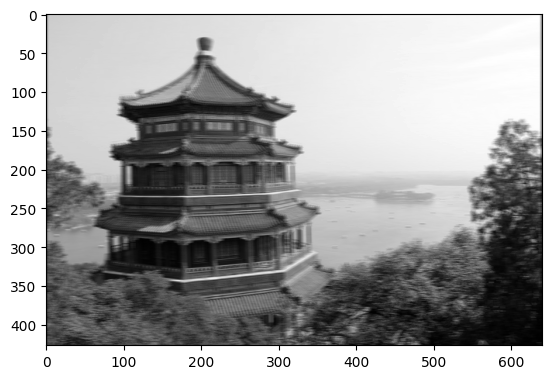

In [24]:
plt.imshow(outputs[0, :, :, 1], cmap="gray") # plot 1st image's 2nd feature map
plt.show()


#### Understanding the Code

1) The pixel intensity for each color channel is represented as a byte from 0 to 255, so we scale these features simply by dividing by 255, to get floats ranging from 0 to 1.

2) Then we create two 7 × 7 filters (one with a vertical white line in the middle, and the other with a horizontal white line in the middle).

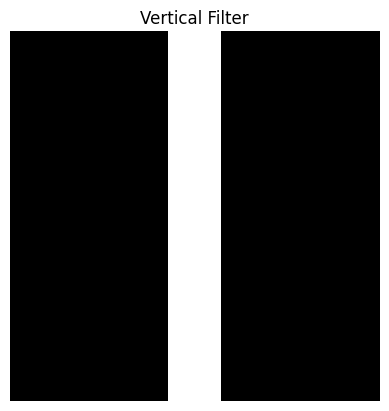

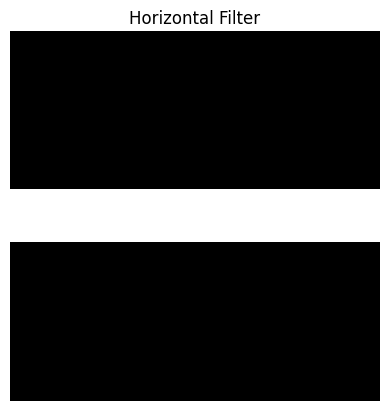

In [25]:
plot_image(filters[:, :, 0, 0],title='Vertical Filter')
plt.show()
print('\n\n\n\n\n\n')
plot_image(filters[:, :, 0, 1],title='Horizontal Filter')
plt.show()

3) We apply them to both images using the tf.nn.conv2d() function, which is part of TensorFlow’s low-level Deep Learning API. In this example, we use zero padding (padding="SAME") and a stride of 1.

#### Now we explain the tf.nn.conv2d() in detail

1) The input is images as a mini-batch (a 4D tensor, as explained earlier).

2) Filters is the set of filters to apply (also a 4D tensor that we defined earlier).

3) Strides is equal to 1, but it could also be a 1D array with four elements, where the two central elements are the vertical and horizontal strides (sh and sw). The first and last elements must currently be equal to 1. They may one day be used to specify a batch stride (to skip some instances) and a channel stride (to skip some of the previous layer’s feature maps or channels).

4) padding must be either "SAME" or "VALID":

#### Padding

#### Same

If set to "SAME", the convolutional layer uses zero padding if necessary. The output size is set to the number of input neurons divided by the stride, rounded up. For example, if the input size is 13 and the stride is 5 then the output size is 3 (i.e., 13 / 5 = 2.6, rounded up to 3). Then zeros are added as evenly as possible around the inputs, as needed. When strides=1, the layer’s outputs will have the same spatial dimensions (width and height) as its inputs, hence the name same.

#### Valid

If set to "VALID", the convolutional layer does not use zero padding and may
ignore some rows and columns at the bottom and right of the input image, depending on the stride. This means that every neuron’s receptive field lies strictly within valid positions inside the input (it does not go out of bounds), hence the name valid.

### Creating a Conv2D layer

In this example we manually defined the filters, but in a real CNN you would normally define filters as trainable variables so the neural net can learn which filters work best, as explained earlier. Instead of manually creating the variables, use the keras.layers.Conv2D layer:

In [26]:
conv = keras.layers.Conv2D(filters=32, kernel_size=3, strides=1, padding="same", activation="relu")

#### Explaining the layer

This code creates a Conv2D layer with 32 filters, each 3 × 3(the kernel = 3 means 3x3), using a stride of 1 (both horizontally and vertically) and "same" padding, and applying the ReLU activation function to its outputs. 

#### Note about CNNs hyperparameters

As you can see, convolutional layers have quite a few hyperparameters: you must choose the number of filters, their height and width, the strides, and the padding type. As always, you can use cross-validation to find the right hyperparameter values, but this is very time-consuming. We will discuss common CNN architectures later, to give you some idea of which hyperparameter values work best in practice.

### Memory Requirements

Another problem with CNNs is that the convolutional layers require a huge amount of RAM. This is especially true during training, because the reverse pass of backpropagation requires all the intermediate values computed during the forward pass.

For example, consider a convolutional layer with 5 × 5 filters, outputting 200 feature maps of size 150 × 100, with stride 1 and "same" padding. If the input is a 150 × 100 RGB image (three channels), then the number of parameters is (5 × 5 × 3 + 1) × 200 = 15,200 (the + 1 corresponds to the bias terms), which is fairly small compared to a fully connected layer. However, each of the 200 feature maps contains 150 × 100 neurons, and each of these neurons needs to compute a weighted sum of its 5 × 5 × 3 = 75 inputs: that’s a total of 225 million float multiplications. Not as bad as a fully connected layer, but still quite computationally intensive. Moreover, if the feature maps are represented using 32-bit floats, then the convolutional layer’s output will occupy 200 × 150 × 100 × 32 = 96 million bits (12 MB) of RAM. And that’s just for one input instance for training —if a training batch contains 100 instances, then this layer will use up 1.2 GB of RAM!

During inference (i.e., when making a prediction for a new instance) the RAM occupied by one layer can be released as soon as the next layer has been computed, so you only need as much RAM as required by two consecutive layers. But during training everything computed during the forward pass needs to be preserved for the reverse pass, so the amount of RAM needed is (at least) the total amount of RAM required by all layers.

## Pooling Layers

Once you understand how convolutional layers work, the pooling layers are quite easy to grasp. Their goal is to subsample (i.e., shrink) the input image in order to reduce the computational load, the memory usage, and the number of parameters (thereby limiting the risk of overfitting).

### Pooling Layer Feature

1) Just like in convolutional layers, each neuron in a pooling layer is connected to the outputs of a limited number of neurons in the previous layer, located within a small rectangular receptive field.

2) You must define its size, the stride, and the padding type, just like before.

#### Important Point
However, a pooling neuron has no weights; all it does is aggregate the inputs using an aggregation function such as the max or mean.

### Working of a Pooling Layer

1) Consider an example where we use a 2 × 2 pooling kernel, with a stride of 2 and no padding.

2) Here, Only the max input value in each receptive field makes it to the next layer, while the other inputs are dropped.

3) For example, consider 4  receptive field with input values 1, 5, 3, 2, so only the max value, 5, is propagated to the next layer.

4) Because of the stride of 2, the output image has half the height and half the width of the input image (rounded down since we use no padding).


### Translational Invariance with Pooling Layers

Other than reducing computations, memory usage, and the number of parameters, a max pooling layer also introduces some level of invariance to small translations.

1)  Assume that there are three images, and we assume that the bright pixels have a lower value than dark pixels and we consider three images (A, B, C) going through a max pooling layer with a 2 × 2 kernel and stride 2.

2) Images B and C are the same as image A, but shifted by one and two pixels to the right. As you can see, the outputs of the max pooling layer for images A and B are identical.

3) This is what translation invariance(i.e. the ablility to stay unchanged) means.

4) For image C, the output is different: it is shifted one pixel to the right (but there is still 75% invariance, i.e. 75% of original composition is still maintained). 

### Conclusion Translational Invariance Max pooling layer

By inserting a max pooling layer every few layers in a CNN, it is possible to get some level of translation invariance at a larger scale. Moreover, max pooling offers a small amount of rotational invariance and a slight scale invariance. Such invariance (even if it is limited) can be useful in cases where the prediction should not depend on these details, such as in classification tasks.

### Disdvantages Max Pooling Layer

However, max pooling has some downsides too. Firstly, it is obviously very destructive: even with a tiny 2 × 2 kernel and a stride of 2, the output will be two times smaller in both directions (so its area will be four times smaller), simply dropping 75% of the input values. And in some applications, invariance is not desirable. Take semantic segmentation (the task of classifying each pixel in an image according to the object that pixel belongs to): obviously, if the input image is translated by one pixel to the right, the output should also be translated by one pixel to the right. The goal in this case is equivariance, not invariance: a small change to the inputs should lead to a corresponding small change in the output.

## TensorFlow Implementation Pooling

### Implementing Max Pooling

Implementing a max pooling layer in TensorFlow is quite easy. The following code creates a max pooling layer using a 2 × 2 kernel. The strides default to the kernel size, so this layer will use a stride of 2 (both horizontally and vertically). By default, it uses "valid" padding (i.e., no padding at all):

In [27]:
max_pool = keras.layers.MaxPool2D(pool_size=2)

### Implementing Average Pooling

To create an average pooling layer, just use AvgPool2D instead of MaxPool2D. As you might expect, it works exactly like a max pooling layer, except it computes the mean rather than the max.

In [28]:
max_pool = keras.layers.AveragePooling2D(pool_size=2)

### Max Pooling VS Average Pooling

Average pooling layers used to be very popular, but people mostly use max pooling layers now, as they generally perform better. This may seem surprising, since computing the mean generally loses less information than computing the max. But on the other hand, max pooling preserves only the strongest features, getting rid of all the meaningless ones, so the next layers get a cleaner signal to work with. Moreover, max pooling offers stronger translation invariance than average pooling, and it requires slightly less compute.

### Pooling Along Different Dimensions.

Note that max pooling and average pooling can be performed along the depth dimension rather than the spatial dimensions, although this is not as common. This can allow the CNN to learn to be invariant to various features. For example, it could learn multiple filters, each detecting a different rotation of the same pattern (such as handwritten digits;), and the depthwise max pooling layer would ensure that the output is the same regardless of the rotation. The CNN could similarly learn to be invariant to anything else: thickness, brightness, skew, color, and so on.

### Pooling Along Spatial Dimension

What it means: Pooling over the width and height of the image or feature map.

How it works: You slide a small window (like 2×2 or 3×3) over the image and perform an operation (e.g., max or average) on the values within that window. This reduces the size of the image (downsampling) but keeps the number of channels (depth) the same.

Goal: To reduce the spatial size and focus on the most important features in each region.

Example:
Imagine a 4×4 grid:

[1  2  3  4
 5  6  7  8
 9  10 11 12
 13 14 
 15 16]
With 2×2 max pooling, we get:

[6  8
 14 16]
Pooling is done on height and width (spatial dimensions).

### Pooling Along Depth Dimension

What it means: Pooling over the channels (depth) at the same spatial location (for example, at one pixel across all channels, basically means that if a pixel has RGB value, i.e. it's 3 channels, hence we pool over these 3 value per pixel which means you are pooling over the depth dimension).

How it works: Instead of pooling over pixels in the width and height, you pool over the responses of multiple filters (channels) at each pixel. You can use max or average pooling to collapse the values across channels into a single value for each spatial location.

Goal: To combine the output of different filters (channels) and make the model invariant to certain variations (like rotation, size, etc.)

Example:
For a single pixel across 3 channels:

[0.5  0.9  0.7]   ← 3 channels
With max pooling over depth, you get:


[0.9]   ← maximum of the 3 values

So now if you read the line "For example, it could learn multiple filters, each detecting a different rotation of the same pattern (such as handwritten digits;), and the depthwise max pooling layer would ensure that the output is the same regardless of the rotation." from the Pooling Along Different Dimensions block what this means is that since you focusing on the pixel's channel, hence you are looking at where is the highest intensity which will keep changing if you rotate the image, hence by pooling along the depth you'll look at all the positions where the intensity is high for the channels and hence the model will be able to perform better even if the digits get rotated.

### Depth Wise pooling in TensorFlow

Keras does not include a depthwise max pooling layer, but TensorFlow’s low-level Deep Learning API does: just use the tf.nn.max_pool() function, and specify the kernel size and strides as 4-tuples (i.e., tuples of size 4). The first three values of each should be 1: this indicates that the kernel size and stride along the batch, height, and width dimensions should be 1. The last value should be whatever kernel size and stride you want along the depth dimension—for example, 3 (this must be a divisor of the input depth; it will not work if the previous layer outputs 20 feature maps, since 20 is not a multiple of 3):

In [29]:
output = tf.nn.max_pool(images, ksize=(1, 1, 1, 3), strides=(1, 1, 1, 3), padding="VALID")

If you want to include this as a layer in your Keras models, wrap it in a Lambda layer (or create a custom Keras layer):

In [30]:
depth_pool = keras.layers.Lambda( lambda X : tf.nn.max_pool(X, ksize=(1, 1, 1, 3), strides=(1, 1, 1, 3), padding="VALID"))

### Global Average Pooling.

One last type of pooling layer that you will often see in modern architectures is the global average pooling layer. It works very differently: all it does is compute the mean of each entire feature map (it’s like an average pooling layer using a pooling kernel with the same spatial dimensions as the inputs).

This means that it just outputs a single number per feature map and per instance, because if you have kernel that is the same size as inputs, then you are basically sliding the entire global pooling layer over the entire feature map and hence it only leads to one output.

Although this is of course extremely destructive (most of the information in the feature map is lost), it can be useful as the output layer.

To create such a layer, simply use the

In [31]:
global_avg_pool = keras.layers.GlobalAvgPool2D()

It’s equivalent to this simple Lambda layer, which computes the mean over the spatial dimensions (height and width):

In [32]:
global_avg_pool = keras.layers.Lambda(lambda X: tf.reduce_mean(X, axis=[1, 2]))

# CNN Architectures

A typical CNN architecture has the following pattern

Typical CNN architectures stack a few convolutional layers (each one generally followed by a ReLU layer), then a pooling layer, then another few convolutional layers (+ReLU), then another pooling layer, and so on.

The image gets smaller and smaller as it progresses through the network, but it also typically gets deeper and deeper (i.e., with more feature maps), thanks to the convolutional layers.

At the end of the network, a regular feedforward neural network is added, composed of a few fully connected layers (+ReLUs), and the final layer outputs the prediction (e.g., a softmax layer that outputs estimated class probabilities).

### Architecture Tips:

A common mistake is to use convolution kernels that are too large. For example, instead of using a convolutional layer with a 5 × 5 kernel, stack two layers with 3 × 3 kernels: it will use fewer parameters and require fewer computations, and it will usually perform better.

One exception is for the first convolutional layer: it can typically have a large kernel (e.g., 5 × 5), usually with a stride of 2 or more: this will reduce the spatial dimension of the image without losing too much information, and since the input image only has three channels in general, it will not be too costly.

## Implementing CNN in TensorFlow

In [33]:
model = keras.models.Sequential([
 keras.layers.Conv2D(64, 7, activation="relu", padding="same",
 input_shape=[28, 28, 1]),
 keras.layers.MaxPooling2D(2),
 keras.layers.Conv2D(128, 3, activation="relu", padding="same"),
 keras.layers.Conv2D(128, 3, activation="relu", padding="same"),
 keras.layers.MaxPooling2D(2),
 keras.layers.Conv2D(256, 3, activation="relu", padding="same"),
 keras.layers.Conv2D(256, 3, activation="relu", padding="same"),
 keras.layers.MaxPooling2D(2),
 keras.layers.Flatten(),
 keras.layers.Dense(128, activation="relu"),
 keras.layers.Dropout(0.5),
 keras.layers.Dense(64, activation="relu"),
 keras.layers.Dropout(0.5),
 keras.layers.Dense(10, activation="softmax")
])

In [34]:
(X_train_full, y_train_full), (X_test, y_test) = keras.datasets.fashion_mnist.load_data()
X_train, X_valid = X_train_full[:-5000], X_train_full[-5000:]
y_train, y_valid = y_train_full[:-5000], y_train_full[-5000:]

X_mean = X_train.mean(axis=0, keepdims=True)
X_std = X_train.std(axis=0, keepdims=True) + 1e-7
X_train = (X_train - X_mean) / X_std
X_valid = (X_valid - X_mean) / X_std
X_test = (X_test - X_mean) / X_std

X_train = X_train[..., np.newaxis]
X_valid = X_valid[..., np.newaxis]
X_test = X_test[..., np.newaxis]

# Explanation for ... in X_test = X_test[..., np.newaxis] https://stackoverflow.com/questions/772124/what-does-the-ellipsis-object-do

In [35]:
X_train.shape

(55000, 28, 28, 1)

## Code Walk Through

1) The first layer uses 64 fairly large filters (7 × 7) but no stride because the input images are not very large. It also sets input_shape=[28, 28, 1], because the images are 28 × 28 pixels, with a single color channel (i.e., grayscale). NOTE:- We are able to pass the the inputs directly without flattening that we had to previously for DNNs.

2) Next we have a max pooling layer which uses a pool size of 2, so it divides each spatial dimension by a factor of 2.

3) Then we repeat the same structure twice: two convolutional layers followed by a max pooling layer. For larger images, we could repeat this structure several more times (the number of repetitions is a hyperparameter you can tune).

4) Note that the number of filters grows as we climb up the CNN toward the output layer (it is initially 64, then 128, then 256): it makes sense for it to grow, since the number of low-level features is often fairly low (e.g., small circles, horizontal lines), but there are many different ways to combine them into higher-level features. It is a common practice to double the number of filters after each pooling layer: since a pooling layer divides each spatial dimension by a factor of 2, we can afford to double the number of feature maps in the next layer without fear of exploding the number of parameters, memory usage, or computational load.

5) Next is the fully connected network, composed of two hidden dense layers and a dense output layer. Note that we must flatten its inputs, since a dense network expects a 1D array of features for each instance. We also add two dropout layers, with a dropout rate of 50% each, to reduce overfitting.

## Training the model

In [36]:
model.compile(loss="sparse_categorical_crossentropy", optimizer="nadam", metrics=["accuracy"])
history = model.fit(X_train, y_train, epochs=10, validation_data=(X_valid, y_valid))
score = model.evaluate(X_test, y_test)
X_new = X_test[:10] # pretend we have new images
y_pred = model.predict(X_new)


Epoch 1/10


1719/1719 [==============================] - 216s 123ms/step - loss: 0.7577 - accuracy: 0.7351 - val_loss: 0.3978 - val_accuracy: 0.8616
Epoch 2/10
1719/1719 [==============================] - 183s 106ms/step - loss: 0.4444 - accuracy: 0.8494 - val_loss: 0.3318 - val_accuracy: 0.8764
Epoch 3/10
1719/1719 [==============================] - 161s 94ms/step - loss: 0.3838 - accuracy: 0.8699 - val_loss: 0.3076 - val_accuracy: 0.8898
Epoch 4/10
1719/1719 [==============================] - 141s 82ms/step - loss: 0.3449 - accuracy: 0.8837 - val_loss: 0.3003 - val_accuracy: 0.8916
Epoch 5/10
1719/1719 [==============================] - 146s 85ms/step - loss: 0.3278 - accuracy: 0.8895 - val_loss: 0.2980 - val_accuracy: 0.8916
Epoch 6/10
1719/1719 [==============================] - 156s 91ms/step - loss: 0.3057 - accuracy: 0.8969 - val_loss: 0.3054 - val_accuracy: 0.8950
Epoch 7/10
1719/1719 [==============================] - 143s 83ms/step - loss: 0.2905 - accuracy: 0.9022 - val_lo

## Advances in CNNs through different architectures

## LeNet (refer the layer composition in the book)

### Details about LeNet

1) MNIST images are 28 × 28 pixels, but they are zero-padded to 32 × 32 pixels and normalized before being fed to the network. The rest of the network does not use any padding, which is why the size keeps shrinking as the image progresses through the network.

2) The average pooling layers are slightly more complex than usual: each neuron computes the mean of its inputs, then multiplies the result by a learnable coefficient (one per map) and adds a learnable bias term (again, one per map), then finally applies the activation function.

3) Most neurons in C3 maps are connected to neurons in only three or four S2 maps (instead of all six S2 maps). See table 1 (page 8) in the original paper(Yann LeCun et al., “Gradient-Based Learning Applied to Document Recognition,” Proceedings of the IEEE 86, no. 11 (1998): 2278–2324.) for details.

4) The output layer is a bit special: instead of computing the matrix multiplication of the inputs and the weight vector, each neuron outputs the square of the Euclidian distance between its input vector and its weight vector. Each output measures how much the image belongs to a particular digit class. The cross-entropy cost function is now preferred, as it penalizes bad predictions much more, producing larger gradients and converging faster.

## AlexNet ((refer the layer composition in the book))

The AlexNet CNN architecture11 won the 2012 ImageNet ILSVRC challenge by a large margin: it achieved a top-five error rate of 17%, while the second best achieved only 26%! It was developed by Alex Krizhevsky (hence the name), Ilya Sutskever, and Geoffrey Hinton. It is similar to LeNet-5, only much larger and deeper, and it was the first to stack convolutional layers directly on top of one another, instead of stacking a pooling layer on top of each convolutional layer.

### Details AlexNet

To reduce overfitting, the authors used two regularization techniques. First, they applied dropout with a 50% dropout rate during training to the outputs of layers F9 and F10. Second, they performed data augmentation by randomly shifting the training images by various offsets, flipping them horizontally, and changing the lighting conditions.

### Local Response Normalization in AlexNet

AlexNet also uses a competitive normalization step immediately after the ReLU step of layers C1 and C3, called local response normalization (LRN): the most strongly activated neurons inhibit other neurons located at the same position in neighboring feature maps (such competitive activation has been observed in biological neurons). This encourages different feature maps to specialize, pushing them apart and forcing them to explore a wider range of features, ultimately improving generalization.  IMPORTANT!!!!!!!!!!!!!!!!!!!!!!!!!!!!! SEE LRN EQN IN TB IN ALEXNET SECTION

### Side Note DATA AUGMENTATION

Data augmentation artificially increases the size of the training set by generating many realistic variants of each training instance. This reduces overfitting, making this a regularization technique. The generated instances should be as realistic as possible: ideally, given an image from the augmented training set, a human should not be able to tell whether it was augmented or not. Simply adding white noise will not help; the modifications should be learnable (white noise is not).

### Positional Augmentation

For example, you can slightly shift, rotate, and resize every picture in the training set by various amounts and add the resulting pictures to the training set. This forces the model to be more tolerant to variations in the position, orientation, and size of the objects in the pictures.

### Lighting Augmentation

For a model that’s more tolerant of different lighting conditions, you can similarly generate many images with various contrasts. In general, you can also flip the pictures horizontally (except for text, and other asymmetrical objects). By combining these transformations, you can greatly increase the size of your training set.

## GoogLeNet

The GoogLeNet architecture was developed by Christian Szegedy et al. from Google Research,13 and it won the ILSVRC 2014 challenge by pushing the top-five error rate below 7%. This great performance came in large part from the fact that the network was much deeper than previous CNNs.

This was made possible by subnetworks called inception modules, which allow GoogLeNet to use parameters much more efficiently than previous architectures: GoogLeNet actually has 10 times fewer parameters than AlexNet (roughly 6 million instead of 60 million).

### IMPORTANT!!!!!!!!!!!!!!! SEE INCEPTION MODULE AND GOOGLENET ARCHITECTURE PART FROM TB IN GOOGLENET SECTION

## ResNet

Kaiming He et al. won the ILSVRC 2015 challenge using a Residual Network (or ResNet), 16 that delivered an astounding top-five error rate under 3.6%. The winning variant used an extremely deep CNN composed of 152 layers (other variants had 34, 50, and 101 layers).

It confirmed the general trend: models are getting deeper and deeper, with fewer and fewer parameters.

The key to being able to train such a deep network is to use skip connections (also called shortcut connections): the signal feeding into a layer is also added to the output of a layer located a bit higher up the stack. Let’s see why this is useful.

### Skip/Shortcut Connections in ResNet

When training a neural network, the goal is to make it model a target function h(x).

If you add the input x to the output of the network (i.e., you add a skip connection), then the network will be forced to model f(x) = h(x) – x rather than h(x). This is called residual learning.

When you initialize a regular neural network, its weights are close to zero, so the network just outputs values close to zero. If you add a skip connection, the resulting network just outputs a copy of its inputs; in other words, it initially models the identity function. If the target function is fairly close to the identity function (which is often the case), this will speed up training considerably.

Moreover, if you add many skip connections, the network can start making progress even if several layers have not started learning yet. Thanks to skip connections, the signal can easily make its way across the whole network. The deep residual network can be seen as a stack of residual units (RUs), where each residual unit is a small neural network with a skip connection.

### ResNet Architecture

It is surprisingly simple. It starts and ends exactly like GoogLeNet (except without a dropout layer), and in between is just a very deep stack of simple residual units. Each residual unit is composed of two convolutional layers (and no pooling layer!), with Batch Normalization (BN) and ReLU activation, using 3 × 3 kernels and preserving spatial dimensions (stride 1, "same" padding).

Note that the number of feature maps is doubled every few residual units, at the same time as their height and width are halved (using a convolutional layer with stride 2). When this happens, the inputs cannot be added directly to the outputs of the residual unit because they don’t have the same shape. To solve this problem, the inputs are passed through a 1 × 1 convolutional layer with stride 2 and the right number of output feature maps.

### ResNet 34

ResNet-34 is the ResNet with 34 layers (only counting the convolutional layers and the fully connected layer)17 containing 3 residual units that output 64 feature maps, 4 RUs with 128 maps, 6 RUs with 256 maps, and 3 RUs with 512 maps. 

### ResNet - 152

ResNets deeper than that, such as ResNet-152, use slightly different residual units. Instead of two 3 × 3 convolutional layers with, say, 256 feature maps, they use three convolutional layers: first a 1 × 1 convolutional layer with just 64 feature maps (4 times less), which acts as a bottleneck layer (as discussed already), then a 3 × 3 layer with 64 feature maps, and finally another 1 × 1 convolutional layer with 256 feature maps (4 times 64) that restores the original depth. ResNet-152 contains 3 such RUs that output 256 maps, then 8 RUs with 512 maps, a whopping 36 RUs with 1,024 maps, and finally 3 RUs with 2,048 maps.

## Xception

Another variant of the GoogLeNet architecture is worth noting: Xception19 (which stands for Extreme Inception) was proposed in 2016 by François Chollet (the author of Keras), and it significantly outperformed Inception-v3 on a huge vision task (350 million images and 17,000 classes).

Just like Inception-v4, it merges the ideas of GoogLeNet and ResNet, but it replaces the inception modules with a special type of layer called a depthwise separable convolution layer (or separable convolution layer for short). These layers had been used before in some CNN architectures, but they were not as central as in the Xception architecture. 

### Separable Convolutional layer in Xception

While a regular convolutional layer uses filters that try to simultaneously capture spatial patterns (e.g., an oval) and crosschannel patterns (e.g., mouth + nose + eyes = face), a separable convolutional layer makes the strong assumption that spatial patterns and cross-channel patterns can be modeled separately.

Thus, it is composed of two parts: the first part applies a single spatial filter for each input feature map, then the second part looks exclusively for cross-channel patterns—it is just a regular convolutional layer with 1 × 1 filters. For this reason, the Xception architecture starts with 2 regular convolutional layers, but then the rest of the architecture uses only separable convolutions (34 in all), plus a few max pooling layers and the usual final layers (a global average pooling layer and a dense output layer)..

#### Xception and Inception

You might wonder why Xception is considered a variant of GoogLeNet, since it contains no inception module at all. Well, as we discussed earlier, an inception module contains convolutional layers with 1 × 1 filters: these look exclusively for crosschannel patterns. However, the convolutional layers that sit on top of them are regular convolutional layers that look both for spatial and cross-channel patterns. So you can think of an inception module as an intermediate between a regular convolutional layer (which considers spatial patterns and cross-channel patterns jointly) and a separable convolutional layer (which considers them separately). In practice, it seems that separable convolutional layers generally perform better.

#### Note Separable CNNs

Separable convolutional layers use fewer parameters, less memory, and fewer computations than regular convolutional layers, and in general they even perform better, so you should consider using them by default (except after layers with few channels).

## SENet

The winning architecture in the ILSVRC 2017 challenge was the Squeeze-andExcitation Network (SENet). This architecture extends existing architectures such as inception networks and ResNets, and boosts their performance. This allowed SENet to win the competition with an astonishing 2.25% top-five error rate!

The extended versions of inception networks and ResNets are called SE-Inception and SE-ResNet, respectively. The boost comes from the fact that a SENet adds a small neural network, called an SE block, to every unit in the original architecture (i.e., every inception module or every residual unit).

### SE Block from SENet

An SE block analyzes the output of the unit it is attached to, focusing exclusively on the depth dimension or the color channel (it does not look for any spatial pattern), and it learns which features are usually most active together. It then uses this information to recalibrate the feature maps.

For example, an SE block may learn that mouths, noses, and eyes usually appear together in pictures: if you see a mouth and a nose, you should expect to see eyes as well. So if the block sees a strong activation in the mouth and nose feature maps, but only mild activation in the eye feature map, it will boost the eye feature map (more accurately, it will reduce irrelevant feature maps). If the eyes were somewhat confused with something else, this feature map recalibration will help resolve the ambiguity.

### SE Block Architecture

An SE block is composed of just three layers: a global average pooling layer, a hidden dense layer using the ReLU activation function, and a dense output layer using the sigmoid activation function.

#### Global Average pooling in SE Block

As earlier, the global average pooling layer computes the mean activation for each feature map: for example, if its input contains 256 feature maps, it will output 256 numbers representing the overall level of response for each filter.

#### Squeeze Layer

The next layer is where the “squeeze” happens: this layer has significantly fewer than 256 neurons typically 16 times fewer than the number of feature maps (e.g., 16 neurons)—so the 256 numbers get compressed into a small vector (e.g., 16 dimensions). 

This is a lowdimensional vector representation (i.e., an embedding) of the distribution of feature responses. This bottleneck step forces the SE block to learn a general representation of the feature combinations.

Finally, the output layer takes the embedding and outputs a recalibration vector containing one number per feature map (e.g., 256), each between 0 and 1. The feature maps are then multiplied by this recalibration vector, so irrelevant features (with a low recalibration score) get scaled down while relevant features (with a recalibration score close to 1) are left alone.

## Implementing a ResNet-34 CNN Using Keras

Most CNN architectures described so far are fairly straightforward to implement. To illustrate the process, let’s implement a ResNet-34 from scratch using Keras. First, let’s create a ResidualUnit layer:

In [37]:
from functools import partial

In [38]:
DefaultConv2D = partial(keras.layers.Conv2D, kernel_size=3, strides=1,
                        padding="SAME", use_bias=False)

In [39]:
class ResidualUnit(keras.layers.Layer):
    def __init__(self, filters, strides=1, activation="relu", **kwargs):
        super().__init__(**kwargs)
        self.activation = keras.activations.get(activation)
        self.main_layers = [
            DefaultConv2D(filters, strides=strides),
            keras.layers.BatchNormalization(),
            self.activation,
            DefaultConv2D(filters),
            keras.layers.BatchNormalization()]
        self.skip_layers = []
        if strides > 1:
            self.skip_layers = [
                DefaultConv2D(filters, kernel_size=1, strides=strides),
                keras.layers.BatchNormalization()]

    def call(self, inputs):
        Z = inputs
        for layer in self.main_layers:
            Z = layer(Z)
        skip_Z = inputs
        for layer in self.skip_layers:
            skip_Z = layer(skip_Z)
        return self.activation(Z + skip_Z)

#### Code Explanation

As you can see, this code matches the ResNet architecture defined before.  In the constructor, we create all the layers we will need: the main layers and the skip layers(only needed if the stride is greater than 1). Then in the call() method, we make the inputs go through the main layers and the skip layers (if any), then we add both outputs and apply the activation function.

Next, we can build the ResNet-34 using a Sequential model, since it’s really just a
long sequence of layers (we can treat each residual unit as a single layer now that we
have the ResidualUnit class):

In [40]:
model = keras.models.Sequential()
model.add(DefaultConv2D(64, kernel_size=7, strides=2,
                        input_shape=[224, 224, 3]))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Activation("relu"))
model.add(keras.layers.MaxPool2D(pool_size=3, strides=2, padding="SAME"))
prev_filters = 64
for filters in [64] * 3 + [128] * 4 + [256] * 6 + [512] * 3:
    strides = 1 if filters == prev_filters else 2
    model.add(ResidualUnit(filters, strides=strides))
    prev_filters = filters
model.add(keras.layers.GlobalAvgPool2D())
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(10, activation="softmax"))

In [41]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 112, 112, 64)      9408      
                                                                 
 batch_normalization (Batch  (None, 112, 112, 64)      256       
 Normalization)                                                  
                                                                 
 activation (Activation)     (None, 112, 112, 64)      0         
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 56, 56, 64)        0         
 g2D)                                                            
                                                                 
 residual_unit (ResidualUni  (None, 56, 56, 64)        74240     
 t)                                                              
                                                      

### Note about ResNet

The only slightly tricky part in this code is the loop that adds the ResidualUnit layers to the model: as explained earlier, the first 3 RUs have 64 filters, then the next 4 RUs have 128 filters, and so on. We then set the stride to 1 when the number of filters is the same as in the previous RU, or else we set it to 2. Then we add the ResidualUnit, and finally we update prev_filters.

## Using Pretrained Models from Keras

In general, you won’t have to implement standard models like GoogLeNet or ResNet manually, since pretrained networks are readily available with a single line of code in the keras.applications package. For example, you can load the ResNet-50 model, pretrained on ImageNet, with the following line of code:

In [42]:
model = keras.applications.resnet50.ResNet50(weights="imagenet")

That’s all! This will create a ResNet-50 model and download weights pretrained on the ImageNet dataset. To use it, you first need to ensure that the images have the right size. A ResNet-50 model expects 224 × 224-pixel images (other models may expect other sizes, such as 299 × 299), so let’s use TensorFlow’s tf.image.resize() function to resize the images we loaded earlier:

In [43]:
images_resized = tf.image.resize(images, [224, 224])

### Note about resizing

The tf.image.resize() will not preserve the aspect ratio. If this is a problem, try cropping the images to the appropriate aspect ratio before resizing. Both operations can be done in one shot with tf.image.crop_and_resize().

### Pre-Processing the inputs

The pretrained models assume that the images are preprocessed in a specific way. In some cases they may expect the inputs to be scaled from 0 to 1, or –1 to 1, and so on. Each model provides a preprocess_input() function that you can use to preprocess your images. These functions assume that the pixel values range from 0 to 255, so we must multiply them by 255 (since earlier we scaled them to the 0–1 range):

In [44]:
inputs = keras.applications.resnet50.preprocess_input(images_resized * 255)

In [45]:
inputs

<tf.Tensor: shape=(2, 224, 224, 3), dtype=float32, numpy=
array([[[[ 126.57551  ,   83.73551  ,   49.83451  ],
         [ 127.061    ,   84.221    ,   50.32     ],
         [ 127.80543  ,   84.96543  ,   51.06443  ],
         ...,
         [ 149.51413  ,  131.67413  ,  123.773125 ],
         [ 150.94382  ,  133.67413  ,  125.773125 ],
         [ 151.061    ,  134.67413  ,  126.773125 ]],

        [[ 127.42037  ,   84.580376 ,   50.679375 ],
         [ 127.13801  ,   84.29801  ,   50.397026 ],
         [ 127.70162  ,   84.86164  ,   50.96064  ],
         ...,
         [ 150.70163  ,  134.58038  ,  126.679375 ],
         [ 151.061    ,  135.71765  ,  127.81666  ],
         [ 151.061    ,  136.22101  ,  128.32     ]],

        [[ 126.061    ,   83.955376 ,   50.585625 ],
         [ 127.061    ,   84.955376 ,   51.585625 ],
         [ 127.79871  ,   85.69311  ,   52.323357 ],
         ...,
         [ 149.79538  ,  135.48663  ,  127.85125  ],
         [ 149.061    ,  136.95538  ,  128.58563

In [46]:
inputs.shape

TensorShape([2, 224, 224, 3])

Now we can use the pretrained model to make predictions:

In [47]:
Y_proba = model.predict(inputs)

1/1 [==============================] - 1s 1s/step


In [48]:
Y_proba

array([[2.0924848e-08, 6.2120854e-08, 3.4899983e-08, ..., 3.0701461e-09,
        1.3317431e-07, 8.0285389e-08],
       [5.9666327e-08, 4.5356686e-05, 2.2303728e-07, ..., 3.2242609e-05,
        2.9164648e-03, 1.0851730e-05]], dtype=float32)

In [49]:
Y_proba.shape

(2, 1000)

### Explaining the Model Prediction

So we gave 2 images as inputs, each of 224 x 224 with 3 channels(RGB), the output Y_proba is a matrix with one row per image and one column per class (in this case, there are 1,000 classes). Which means that the original model was trained on a set that had 1000 classes.

If you want to display the top K predictions, including the class name and the estimated probability of each predicted class, use the decode_predictions() function. For each image, it returns an array containing the top K predictions, where each prediction is represented as an array containing the class identifier, its name, and the corresponding confidence score:

#### Top-K

In [50]:
top_K = keras.applications.resnet50.decode_predictions(Y_proba, top=3)
top_K


[[('n02825657', 'bell_cote', 0.8234557),
  ('n03877845', 'palace', 0.06752694),
  ('n03781244', 'monastery', 0.04187935)],
 [('n03530642', 'honeycomb', 0.49813053),
  ('n13040303', 'stinkhorn', 0.33957794),
  ('n02206856', 'bee', 0.043453205)]]

In [51]:
for image_index in range(len(images)):
    print("Image #{}".format(image_index))
    for class_id, name, y_proba in top_K[image_index]:
        print("  {} - {:12s} {:.2f}%".format(class_id, name, y_proba * 100))
    print()

Image #0
  n02825657 - bell_cote    82.35%
  n03877845 - palace       6.75%
  n03781244 - monastery    4.19%

Image #1
  n03530642 - honeycomb    49.81%
  n13040303 - stinkhorn    33.96%
  n02206856 - bee          4.35%



In [52]:
top_K

[[('n02825657', 'bell_cote', 0.8234557),
  ('n03877845', 'palace', 0.06752694),
  ('n03781244', 'monastery', 0.04187935)],
 [('n03530642', 'honeycomb', 0.49813053),
  ('n13040303', 'stinkhorn', 0.33957794),
  ('n02206856', 'bee', 0.043453205)]]

## Pretrained Models for Transfer Learning

If you want to build an image classifier but you do not have enough training data, then it is often a good idea to reuse the lower layers of a pretrained model. For example, let’s train a model to classify pictures of flowers, reusing a pretrained Xception model. First, let’s load the dataset using TensorFlow Datasets.

In [53]:
# import tensorflow_datasets as tfds

In [54]:
# dataset, info = tfds.load("tf_flowers", as_supervised=True, with_info=True)
# dataset_size = info.splits["train"].num_examples # 3670
# class_names = info.features["label"].names # ["dandelion", "daisy", ...]
# n_classes = info.features["label"].num_classes # 5

Note that you can get information about the dataset by setting with_info=True. Here, we get the dataset size and the names of the classes. Unfortunately, there is only a "train" dataset, no test set or validation set, so we need to split the training set. The TF Datasets project provides an API for this. For example, let’s take the first 10% of the dataset for testing, the next 15% for validation, and the remaining 75% for training:

In [55]:
# test_split, valid_split, train_split = tfds.Split.TRAIN.subsplit([10, 15, 75])
# test_set = tfds.load("tf_flowers", split=test_split, as_supervised=True)
# valid_set = tfds.load("tf_flowers", split=valid_split, as_supervised=True)
# train_set = tfds.load("tf_flowers", split=train_split, as_supervised=True)

as_supervised :-	bool, if True, the returned tf.data.Dataset will have a 2-tuple structure (input, label) according to builder.info.supervised_keys. If False, the default, the returned tf.data.Dataset will have a dictionary with all the features.

Next we must preprocess the images. The CNN expects 224 × 224 images, so we need to resize them. We also need to run the images through Xception’s preprocess_input() function, as discussed before, each pre-trained model comes with their own preprocess function:

In [56]:
def preprocess(image, label):
    resized_image = tf.image.resize(image, [224, 224])
    final_image = keras.applications.xception.preprocess_input(resized_image)
    return final_image, label


Let’s apply this preprocessing function to all three datasets, shuffle the training set, and add batching and prefetching to all the datasets:

In [57]:
# batch_size = 32
# train_set = train_set.shuffle(1000)
# train_set = train_set.map(preprocess).batch(batch_size).prefetch(1)
# valid_set = valid_set.map(preprocess).batch(batch_size).prefetch(1)
# test_set = test_set.map(preprocess).batch(batch_size).prefetch(1)

If you want to perform some data augmentation, change the preprocessing function for the training set, adding some random transformations to the training images. For example, use tf.image.random_crop() to randomly crop the images, use tf.image.random_flip_left_right() to randomly flip the images horizontally, and so on, see the “Pretrained Models for Transfer Learning” section of the author's notebook for an example.

### keras.preprocessing.image.ImageDataGenerator

The keras.preprocessing.image.ImageDataGenerator class makes it easy to load images from disk and augment them in various ways: you can shift each image, rotate it, rescale it, flip it horizontally or vertically, shear it, or apply any transformation function you want to it. This is very convenient for simple projects. However, building a tf.data pipeline has many advantages: it can read the images efficiently (e.g., in parallel) from any source, not just the local disk and directly give it to the gpu, like we saw using prefetch and prefetch experimenatal; you can manipulate the Dataset as you wish; and if you write a preprocessing function based on tf.image operations, this function can be used both in the tf.data pipeline and in the model you will deploy to production.

### Loading and Training the Pre-trained model

Next let’s load an Xception model, pretrained on ImageNet. We exclude the top of the network by setting include_top=False: this excludes the global average pooling layer and the dense output layer. We then add our own global average pooling layer, based on the output of the base model, followed by a dense output layer with one unit per class, using the softmax activation function. Finally, we create the Keras Model:

In [58]:
n_classes = 5

In [59]:
base_model = keras.applications.xception.Xception(weights="imagenet",
 include_top=False)
avg = keras.layers.GlobalAveragePooling2D()(base_model.output)
output = keras.layers.Dense(n_classes, activation="softmax")(avg)
model = keras.Model(inputs=base_model.input, outputs=output)

As explained in Chapter 11, it’s usually a good idea to freeze the weights of the pre‐trained layers, at least at the beginning of training:

In [60]:
for layer in base_model.layers:
    layer.trainable = False

#### Important note about freezing layers
Since our model uses the base model’s layers directly, rather than the base_model object itself, setting base_model.trainable=False would have no effect.

#### Finally, we can compile the model and start training:

In [61]:
optimizer = tf.keras.optimizers.legacy.SGD(learning_rate=0.2, momentum=0.9, decay=0.01)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,metrics=["accuracy"])

In [62]:
# history = model.fit(train_set, epochs=5, validation_data=valid_set)
# # 

#### This will be very slow, unless you have a GPU.

In [63]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, None, None, 3)]      0         []                            
                                                                                                  
 block1_conv1 (Conv2D)       (None, None, None, 32)       864       ['input_2[0][0]']             
                                                                                                  
 block1_conv1_bn (BatchNorm  (None, None, None, 32)       128       ['block1_conv1[0][0]']        
 alization)                                                                                       
                                                                                                  
 block1_conv1_act (Activati  (None, None, None, 32)       0         ['block1_conv1_bn[0][0]'] 

#### Final training after un-freezing the layers

After training the model for a few epochs, its validation accuracy should reach about 75–80% and stop making much progress. This means that the top layers are now pretty well trained, so we are ready to unfreeze all the layers (or you could try unfreezing just the top ones) and continue training (don’t forget to compile the model when you freeze or unfreeze layers). This time we use a much lower learning rate to avoid damaging the pretrained weights:

In [64]:
for layer in base_model.layers:
    layer.trainable = True

In [65]:
optimizer = tf.keras.optimizers.legacy.SGD(learning_rate=0.01, momentum=0.9, decay=0.001)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,metrics=["accuracy"])

In [66]:
# history = model.fit(train_set, epochs=5, validation_data=valid_set)
# # 

## Classification and Localization

Localizing an object in a picture can be expressed as a regression task: to predict a bounding box around the object, a common approach is to predict the horizontal and vertical coordinates of the object’s center, as well as its height and width.

This means we have four numbers to predict. It does not require much change to the model; we just need to add a second dense output layer with four units (typically on top of the global average pooling layer), and it can be trained using the MSE loss:

In [67]:
base_model = keras.applications.xception.Xception(weights="imagenet",include_top=False)

In [68]:
avg = keras.layers.GlobalAveragePooling2D()(base_model.output)
class_output = keras.layers.Dense(n_classes, activation="softmax")(avg)
loc_output = keras.layers.Dense(4)(avg)
model = keras.Model(inputs=base_model.input,
 outputs=[class_output, loc_output])
model.compile(loss=["sparse_categorical_crossentropy", "mse"],
 loss_weights=[0.8, 0.2], # depends on what you care most about
 optimizer=optimizer, metrics=["accuracy"])

In [69]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, None, None, 3)]      0         []                            
                                                                                                  
 block1_conv1 (Conv2D)       (None, None, None, 32)       864       ['input_3[0][0]']             
                                                                                                  
 block1_conv1_bn (BatchNorm  (None, None, None, 32)       128       ['block1_conv1[0][0]']        
 alization)                                                                                       
                                                                                                  
 block1_conv1_act (Activati  (None, None, None, 32)       0         ['block1_conv1_bn[0][0]'

### Labelled Data Training Problem

But now we have a problem: the flowers dataset does not have bounding boxes around the flowers. So, we need to add them ourselves. This is often one of the hardest and most costly parts of a Machine Learning project: getting the labels. It’s a good idea to spend time looking for the right tools. To annotate images with bounding boxes, you may want to use an open source image labeling tool like VGG Image Annotator, LabelImg, OpenLabeler, or ImgLab, or perhaps a commercial tool like LabelBox or Supervisely. You may also want to consider crowdsourcing platforms such as Amazon Mechanical Turk if you have a very large number of images to annotate. However, it is quite a lot of work to set up a crowdsourcing platform, prepare the form to be sent to the workers, supervise them, and ensure that the quality of the bounding boxes they produce is good, so make sure it is worth the effort. If there are just a few thousand images to label, and you don’t plan to do this frequently, it may be preferable to do it yourself. 

Adriana Kovashka et al. has written a very practical paper about crowdsourcing in computer vision(Adriana Kovashka et al., “Crowdsourcing in Computer Vision,” Foundations and Trends in Computer Graphics and Vision 10, no. 3 (2014): 177–243.). You can check it out, even if you do not plan to use crowdsourcing.

### Training assuming you have the labelled data

Let’s suppose you’ve obtained the bounding boxes for every image in the flowers dataset (for now we will assume there is a single bounding box per image). You then need to create a dataset whose items will be batches of preprocessed images along with their class labels and their bounding boxes. Each item should be a tuple of the form (images, (class_labels, bounding_boxes)). Then you are ready to train your model!

#### Warning about Data for Training

The bounding boxes should be normalized so that the horizontal and vertical coordinates, as well as the height and width, all range from 0 to 1. Also, it is common to predict the square root of the height and width rather than the height and width directly: this way, a 10-pixel error for a large bounding box will not be penalized as much as a 10-pixel error for a small bounding box.

### tf.keras.metrics.MeanIoU

The MSE often works fairly well as a cost function to train the model, but it is not a great metric to evaluate how well the model can predict bounding boxes. The most common metric for this is the Intersection over Union (IoU): the area of overlap between the predicted bounding box and the target bounding box, divided by the area of their union. In tf.keras, it is implemented by the tf.keras.metrics.MeanIoU class.

## Object Detection

The task of classifying and localizing multiple objects in an image is called object detection. Until a few years ago, a common approach was to take a CNN that was trained to classify and locate a single object, then slide it across the image.

This technique is fairly straightforward, but as you can see it will detect the same object multiple times, at slightly different positions. Some post-processing will then be needed to get rid of all the unnecessary bounding boxes. A common approach for this is called non-max suppression. Here’s how you do it:

1) Suppose you are trying to identify flowers in an image. First, you need to add an extra objectness output to your CNN, to estimate the probability that a flower is indeed present in the image (alternatively, you could add a “no-flower” class, but this usually does not work as well). It must use the sigmoid activation function, and you can train it using binary cross-entropy loss. Then get rid of all the bounding boxes for which the objectness score is below some threshold: this will drop all the bounding boxes that don’t actually contain a flower.

2) Find the bounding box with the highest objectness score, and get rid of all the other bounding boxes that overlap a lot with it (e.g., with an IoU greater than 60%).

3) Repeat step two until there are no more bounding boxes to get rid of.

#### This simple approach to object detection works pretty well, but it requires running the CNN many times, so it is quite slow. Fortunately, there is a much faster way to slide a CNN across an image: using a fully convolutional network (FCN).

## Fully Convolutional Networks

The idea of FCNs was first introduced in a 2015 paper by Jonathan Long et al., for semantic segmentation (the task of classifying every pixel in an image according to the class of the object it belongs to).

The authors pointed out that you could replace the dense layers at the top of a CNN by convolutional layers.

### Example FCN

To understand this, let’s look at an example: suppose a dense layer with 200 neurons sits on top of a convolutional layer that outputs 100 feature maps, each of size 7 × 7 (this is the feature map size, not the kernel size).

Each neuron will compute a weighted sum of all 100 × 7 × 7 activations from the convolutional layer (plus a bias term).

Now let’s see what happens if we replace the dense layer with a convolutional layer using 200 filters, each of size 7 × 7, and with "valid" padding.

This layer will output 200 feature maps, each 1 × 1 (since the kernel size of the CNN layer is exactly the size of the  feature maps that it is getting as inputs so 7 x 7 kernels of the output CNN layers will roll over/slide over the feature maps of size 7 x 7 and hence we get as output each 1 × 1 and we are using "valid" padding so no zero padding is done).

In other words, it will output 200 numbers, just like the dense layer did; and if you look closely at the computations performed by a convolutional layer, you will notice that these numbers will be precisely the same as those the dense layer produced. The only difference is that the dense layer’s output was a tensor of shape [batch size, 200], while the convolutional layer will output a tensor of shape [batch size, 1, 1, 200].

### Note about using CNNs in the output layer

To convert a dense layer to a convolutional layer, the number of filters in the convolutional layer must be equal to the number of units in the dense layer, the filter size must be equal to the size of the input feature maps, and you must use "valid" padding. The stride may be set to 1 or more, as we will see shortly.

### FCN training

Why is this important? Well, while a dense layer expects a specific input size (since it has one weight per input feature), a convolutional layer will happily process images of any size(There is one small exception: a convolutional layer using "valid" padding will complain if the input size is smaller than the kernel size, since if you slide a kernel of size 5 x 5 over an input of size 3 x 3 then it's a problem), however, it does expect its inputs to have a specific number of channels like 3 for RGB or more if it also has infrared since each kernel contains a different set of weights for each input channel). Since an FCN contains only convolutional layers (and pooling layers, which have the same property), it can be trained and executed on images of any size!

#### Training Example

For example, suppose we’d already trained a CNN for flower classification and localization. It was trained on 224 × 224 images, and it outputs 10 numbers: outputs 0 to 4 are sent through the softmax activation function, and this gives the class probabilities (one per class); output 5 is sent through the logistic activation function, and this gives the objectness score; outputs 6 to 9 do not use any activation function, and they rep‐ resent the bounding box’s center coordinates, as well as its height and width.

We can now convert its dense layers to convolutional layers. In fact, we don’t even need to retrain it; we can just copy the weights from the dense layers to the convolutional layers! Alternatively, we could have converted the CNN into an FCN before training.

#### Training Scenario

##### The CNN layer before the output layer

Now suppose the last convolutional layer before the output layer (also called the bottleneck layer) outputs 7 × 7 feature maps when the network is fed a 224 × 224 image. If we feed the FCN a 448 × 448 image, the bottleneck layer will now output 14 × 14 feature maps(Note!!! This assumes we used only "same" padding in the network and hence get 14 X 14 as output, however, indeed using "valid" padding would reduce the size of the feature maps. Moreover, 448 can be neatly divided by 2 several times until we reach 7, without any rounding error. If any layer uses a different stride than 1 or 2, then there may be some rounding error, so again the feature maps may end up being smaller).

##### CNN as the output layer


Now, Since the dense output layer was replaced by a convolutional layer using 10 filters of size 7 × 7, with "valid" padding and stride 1, the output will be composed of 10 features maps, each of size 8 × 8 (since 14 – 7 + 1 = 8). 

In other words, the FCN will process the whole image only once, and it will output an 8 × 8 grid, now read this carefully, because earlier for CNN as output layer, we said that :-- (This layer will output 200 feature maps, each 1 × 1 since the kernel is exactly the size of the input feature maps and we are using "valid" padding. In other words, it will output 200 numbers), so now why 8 x 8? well because in this particular example  the input that the CNN of the output layer is getting has the size of 14 x 14 and after (14 – 7 + 1 = 8) we get 8 x 8. Now, just like the dense layer did where each cell contains 10 numbers (5 class probabilities, 1 objectness score, and 4 bounding box coordinates), hence there will be a total of 64 cell each containing 10 values. It’s exactly like taking the original CNN and sliding it across the image using 8 steps per row and 8 steps per column.

#### Important point
To visualize this, imagine chopping the original image into a 14 × 14 grid, then sliding a 7 × 7 window across this grid; there will be 8 × 8 = 64 possible locations for the window, hence 8 × 8 predictions.

## You Only Look Once (YOLO)

YOLO is an extremely fast and accurate object detection architecture proposed byJoseph Redmon et al. in a 2015 paper, and subsequently improved in 2016 (YOLOv2) and in 2018 (YOLOv3). It is so fast that it can run in real time on a video.

### YOLO V3

YOLOv3’s architecture is quite similar to the one we just discussed, but with a few 
important differences:

1) It outputs five bounding boxes for each grid cell (instead of just one), and each bounding box comes with an objectness score. It also outputs 20 class probabilities per grid cell, as it was trained on the PASCAL VOC dataset, which contains 20 classes. That’s a total of 45 numbers per grid cell: 5 bounding boxes, each with 4 coordinates, plus 5 objectness scores, plus 20 class probabilities.

2) Instead of predicting the absolute coordinates of the bounding box centers, YOLOv3 predicts an offset relative to the coordinates of the grid cell, where (0, 0) means the top left of that cell and (1, 1) means the bottom right. For each grid cell, YOLOv3 is trained to predict only bounding boxes whose center lies in that cell (but the bounding box itself generally extends well beyond the grid cell, meaning the entity inside the box may be big and extend beyond the particular grid cell). YOLOv3 applies the logistic activation function to the bounding box coordinates to ensure they remain in the 0 to 1 range.

#### Bounding Boxes of YoloV3

1) Before training the neural net, YOLOv3 finds five representative bounding box dimensions, called anchor boxes (or bounding box priors).

2)  It does this by applying the K-Means algorithm to the height and width of the training set bounding boxes(of course this is the time consuming process of labelling the objects in the image, basically creating the bounding boxes).

##### Example Bounding boxes

1) For example, if the training images contain many pedestrians, then one of the anchor boxes will likely have the dimensions of a typical pedestrian. Then when the neural net predicts five bounding boxes per grid cell, it actually predicts how much to rescale each of the anchor boxes. 

2) For example, suppose one anchor box is 100 pixels tall and 50 pixels wide, and the network predicts, say, a vertical rescaling factor of 1.5 and a horizontal rescaling of 0.9 (for one of the grid cells). This will result in a predicted bounding box of size 150 × 45 pixels. 

3) To be more precise, for each grid cell and each anchor box, the network predicts the log of the vertical and horizontal rescaling factors. Having these priors makes the network more likely to predict bounding boxes of the appropriate dimensions, and it also speeds up training because it will more quickly learn what reasonable bounding boxes look like.

4) The network is trained using images of different scales: every few batches during training, the network randomly chooses a new image dimension (from 330 × 330 to 608 × 608 pixels). This allows the network to learn to detect objects at different scales. Moreover, it makes it possible to use YOLOv3 at different scales: the smaller scale will be less accurate but faster than the larger scale, so you can choose the right trade-off for your use case.

#### There are a few more innovations that are interesting, such as the use of skip connections to recover some of the spatial resolution that is lost in the CNN (we will discuss this shortly, when we look at semantic segmentation). In the 2016 paper, the authors introduce the YOLO9000 model that uses hierarchical classification: the model predicts a probability for each node in a visual hierarchy called WordTree. This makes it possible for the network to predict with high confidence that an image represents, say, a dog, even though it is unsure what specific type of dog.

## Mean Average Precision in Object Detection

A very common metric used in object detection tasks is the mean Average Precision (mAP). To understand this met‐
ric, let’s go back to two classification metrics we discussed in Chapter 3: precision and recall. Remember the trade-off: the higher the recall, the lower the precision. You can visualize this in a precision/recall curve (see Figure 3-5). To summarize this curve into a single number, we could compute its area under the curve (AUC). But note that the precision/recall curve may contain a few sections where precision actually goes up when recall increases, especially at low recall values (you can see this at the top left of Figure 3-5). This is one of the motivations for the mAP metric.

### Precision Recall in MAP

Suppose the classifier has 90% precision at 10% recall, but 96% precision at 20% recall. There’s really no trade-off here: it simply makes more sense to use the classifier at 20% recall rather than at 10% recall, as you will get both higher recall and higher precision. 

So instead of looking at the precision at 10% recall, we should really be looking at the maximum precision that the classifier can offer with at least 10% recall.

It would be 96%, not 90%. Therefore, one way to get a fair idea of the model’s performance is to compute the maximum precision you can get with at least 0% recall, then 10% recall, 20%, and so on up to 100%, and then calculate the mean of these maximum precisions. This is called the Average Precision (AP) metric. Now when there are more than two classes, we can compute the AP for each class, and then compute the mean AP (mAP). That’s it!

### Complexity in object detection

In an object detection system, there is an additional level of complexity: what if the system detected the correct class, but at the wrong location (i.e., the bounding box is completely off)? Surely we should not count this as a positive prediction. One approach is to define an IOU threshold: for example, we may consider that a prediction is correct only if the IOU is greater than, say, 0.5, and the predicted class is correct. The corresponding mAP is generally noted mAP@0.5 (or mAP@50%, or sometimes just AP50). In some competitions (such as the PASCAL VOC challenge), this is what is done. In others (such as the COCO competition), the mAP is computed for different IOU thresholds (0.50, 0.55, 0.60, …, 0.95), and the final metric is the mean of all these mAPs (noted AP@[.50:.95] or AP@[.50:0.05:.95]). Yes, that’s a mean mean average.

## Semantic Segmentation

In semantic segmentation, each pixel is classified according to the class of the object it belongs to (e.g., road, car, pedestrian, building, etc.).

Note that different objects of the same class are not distinguished. For example, if there is a group of bicycles on the right side of the segmented image, they end up as one big lump of pixels. The main difficulty in this task is that when images go through a regular CNN, they gradually lose their spatial resolution (due to the layers with strides greater than 1); so, a regular CNN may end up knowing that there’s a person somewhere in the bottom left of the image, but it will not be much more precise than that.

### Solving the segmentation problem

Just like for object detection, there are many different approaches to tackle this problem, some quite complex. However, a fairly simple solution was proposed in the 2015 paper by Jonathan Long et al.

The authors start by taking a pre‐trained CNN and turning it into an FCN. The CNN applies an overall stride of 32 to the input image (i.e., if you add up all the strides greater than 1), meaning the last layer outputs feature maps that are 32 times smaller than the input image. This is clearly too coarse, so they add a single upsampling layer that multiplies the resolution by 32.

### Upsampling a layer

There are several solutions available for upsampling (increasing the size of an image), such as bilinear interpolation, but that only works reasonably well up to ×4 or ×8. Instead, they use a transposed convolutional layer(This type of layer is sometimes referred to as a deconvolution layer, but it does not perform what mathematicians call a deconvolution, so this name should be avoided): it is equivalent to first stretching the image by inserting empty rows and columns (full of zeros), then performing a regular convolution.

Alternatively, some people prefer to think of it as a regular convolutional layer that uses fractional strides (e.g., 1/2, basically since you are using a smaller stride, hence you're preserving a lot of original feature from the image). The transposed convolutional layer can be initialized to perform something close to linear interpolation, but since it is a trainable layer, it will learn to do better during training. In tf.keras, you can use the Conv2DTranspose layer.

This solution is OK, but still too imprecise. To do better, the authors added skip connections from lower layers: for example, they upsampled the output image by a factor of 2 (instead of 32), and they added the output of a lower layer that had this double resolution. Then they upsampled the result by a factor of 16, leading to a total upsampling factor of 32.

This recovered some of the spatial resolution that was lost in earlier pooling layers. In their best architecture, they used a second similar skip connection to recover even finer details from an even lower layer. In short, the output of the original CNN goes through the following extra steps: upscale ×2, add the output of a lower layer (of the appropriate scale), upscale ×2, add the output of an even lower layer, and finally upscale ×8. It is even possible to scale up beyond the size of the original image: this can be used to increase the resolution of an image, which is a technique called super-resolution.

### Warning Transpose Layer
In a transposed convolutional layer, the stride defines how much the input will be stretched, not the size of the filter steps, so the larger the stride, the larger the output (unlike for convolutional layers or pooling layers).

## TensorFlow Convolution Operations

TensorFlow also offers a few other kinds of convolutional layers:

### keras.layers.Conv1D
Creates a convolutional layer for 1D inputs, such as time series or text (sequences of letters or words).

### keras.layers.Conv3D
Creates a convolutional layer for 3D inputs, such as 3D PET scans.

### dilation_rate
Setting the dilation_rate hyperparameter of any convolutional layer to a value of 2 or more creates an à-trous convolutional layer (“à trous” is French for “with holes”). This is equivalent to using a regular convolutional layer with a filter dilated by inserting rows and columns of zeros (i.e., holes). For example, a 1 × 3 filter equal to [[1,2,3]] may be dilated with a dilation rate of 4, resulting in a dilated filter of [[1, 0, 0, 0, 2, 0, 0, 0, 3]]. This lets the convolutional layer have a larger receptive field at no computational price and using no extra parameters.

### tf.nn.depthwise_conv2d()
Can be used to create a depthwise convolutional layer (but you need to create the variables yourself). It applies every filter to every individual input channel independently. Thus, if there are fn filters and fn′ input channels, then this will output fn × fn′ feature maps.

## Instance Segmentation

Instance segmentation is similar to semantic segmentation, but instead of merging all objects of the same class into one big lump, each object is distinguished from the others (e.g., it identifies each individual bicycle). At present, the instance segmentation models available in the TensorFlow Models project are based on the Mask R-CNN architecture(regions with convolutional neural networks), which was proposed in a 2017 paper(Kaiming He et al., “Mask R-CNN,” arXiv preprint arXiv:1703.06870 (2017).):  it extends the Faster R-CNN model by additionally producing a pixel mask for each bounding box. So not only do you get a bounding box around each object, with a set of estimated class probabilities, but you also get a pixel mask that locates pixels in the bounding box that belong to the object.

## New Architectures

New novel architectures, such as Geoffrey Hinton’s capsule networks (https://www.youtube.com/watch?v=pPN8d0E3900&list=PLuTYjXW7aAt3HLCATBOkkXtifCVAm0O_A) (https://www.youtube.com/watch?v=2Kawrd5szHE), code in author's notebook.